In [1]:
import pyforest
import warnings
warnings.filterwarnings("ignore")

# Tools for preprocessing input data
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

import seaborn as sns
# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
#from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
import distance

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.sentiment.vader import SentimentIntensityAnalyzer


Using TensorFlow backend.


## 1. Load and check data
Load the data, check the size and feature types and remove unvaluable features

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
print("Number of data points:",train_df.shape[0])

Number of data points: 404290


In [5]:
print(train_df.is_duplicate.value_counts())
print("-----------------------------------")
print(train_df.is_duplicate.value_counts(normalize=True))

0    255027
1    149263
Name: is_duplicate, dtype: int64
-----------------------------------
0    0.630802
1    0.369198
Name: is_duplicate, dtype: float64


Text(0, 0.5, 'percentage')

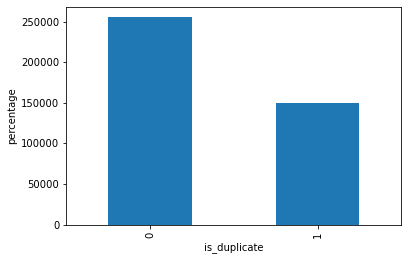

In [6]:
train_df.groupby("is_duplicate")['id'].count().plot.bar()
plt.ylabel('percentage')

[Text(0, 0.5, 'Percent')]

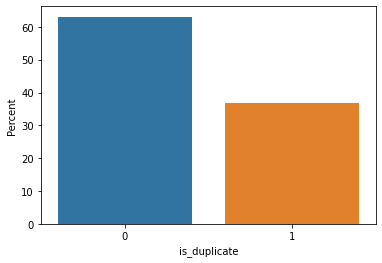

In [7]:
ax = sns.barplot(x="is_duplicate", y="is_duplicate", data=train_df, estimator=lambda x: len(x) / len(train_df) * 100)
ax.set(ylabel="Percent")

In [8]:
qids = pd.Series(train_df['qid1'].tolist() + train_df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print('Number of unique question in question1:', train_df['qid1'].nunique())
print('Number of unique question in question2:', train_df['qid2'].nunique())
print ('Total number of unique questions: {}\n'.format(unique_qs))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of unique question in question1: 290654
Number of unique question in question2: 299364
Total number of unique questions: 537933



Checking for Duplicates

In [9]:
#checking whether there are any repeated pair of questions

pair_duplicates = train_df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - train_df.shape[0])

Number of duplicate questions 0


Maximum number of times a single question is repeated: 157



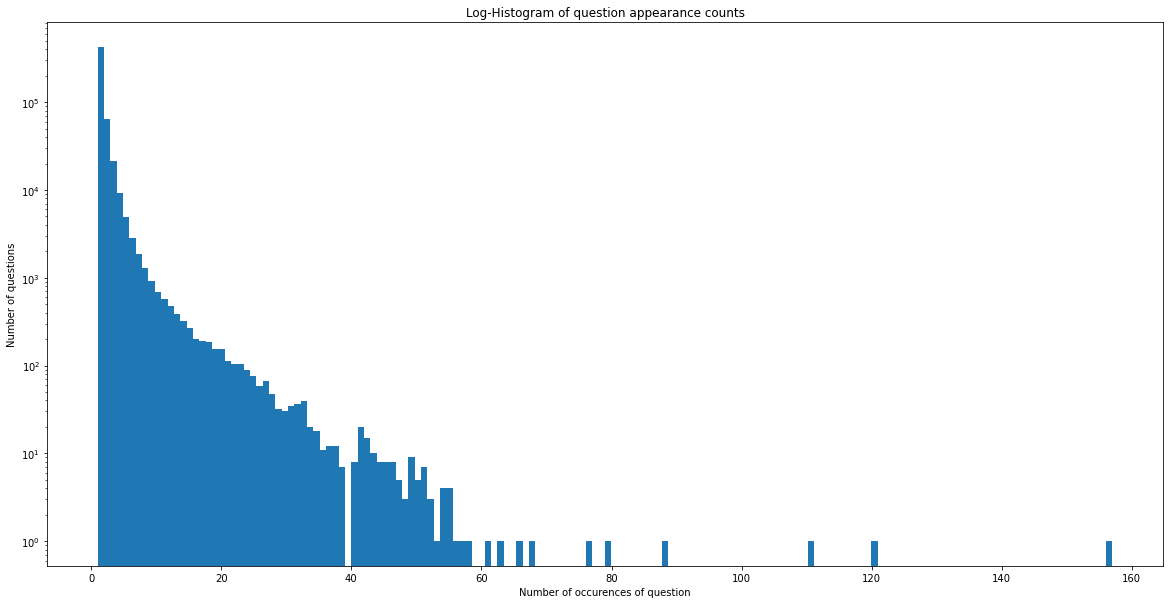

In [10]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonpositive='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

Checking for NULL values 

In [11]:
# Check for Null values(percentage)
print(train_df.isnull().sum())

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64


In [12]:
# Filling the null values with ' '
train_df = train_df.fillna('')

In [13]:
train_df['q1len'] = train_df['question1'].str.len() 
train_df['q2len'] = train_df['question2'].str.len()
train_df['q1_n_words'] = train_df['question1'].apply(lambda row: len(row.split(" ")))
train_df['q2_n_words'] = train_df['question2'].apply(lambda row: len(row.split(" ")))

In [14]:
train_df

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7
...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,85,79,14,13
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1,41,42,8,9
404287,404287,537928,537929,What is one coin?,What's this coin?,0,17,17,4,3
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,94,127,17,25


In [15]:
def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip().replace('?', ''), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip().replace('?', ''), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
train_df['word_share'] = train_df.apply(normalized_word_share, axis=1)

In [16]:
print ("Minimum length of the questions in question1 : " , min(train_df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(train_df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", train_df[train_df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", train_df[train_df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


In [17]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,0.478261
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,0.250000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,0.150000


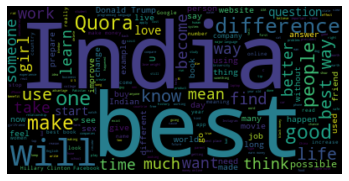

In [18]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(' '.join(train_df['question1']))
#wordcloud = WordCloud().generate(train_data['clean_review'])

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

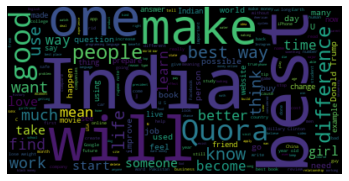

In [19]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(' '.join(train_df['question2']))
#wordcloud = WordCloud().generate(train_data['clean_review'])

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

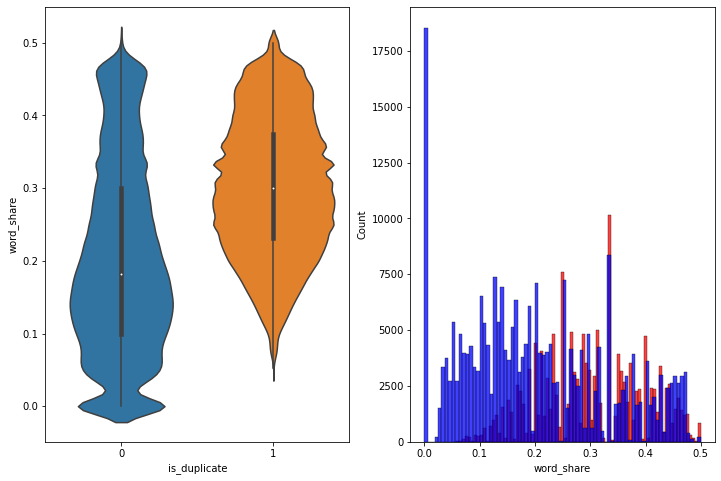

In [20]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = train_df[0:])

plt.subplot(1,2,2)
sns.histplot(train_df[train_df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.histplot(train_df[train_df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity

The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

# Prepocessing

In [21]:
def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
        text = [w for w in text if not w in stop_words]
    
    text = " ".join(text)
    
    # Remove punctuation from text
    # text = "".join([c for c in text if c not in punctuation])

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    # text = re.sub(r"\0s", "0", text) # It doesn't make sense to me
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

In [22]:
train_df['question1_clean'] = train_df['question1'].apply(text_to_wordlist)
train_df['question2_clean'] = train_df['question2'].apply(text_to_wordlist)

# Features Extraction

In [23]:
# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

# Extract fuzzy-wuzzy features
def extract_features (df):
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [24]:
train_df = extract_features(train_df)

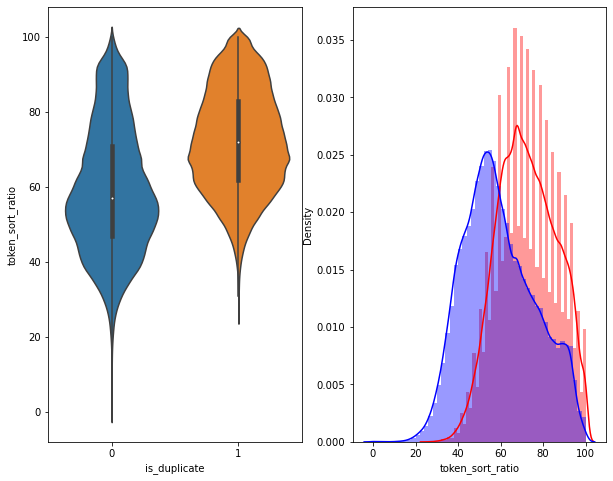

In [25]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = train_df[0:] , )

plt.subplot(1,2,2)
sns.distplot(train_df[train_df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(train_df[train_df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue')
plt.show()

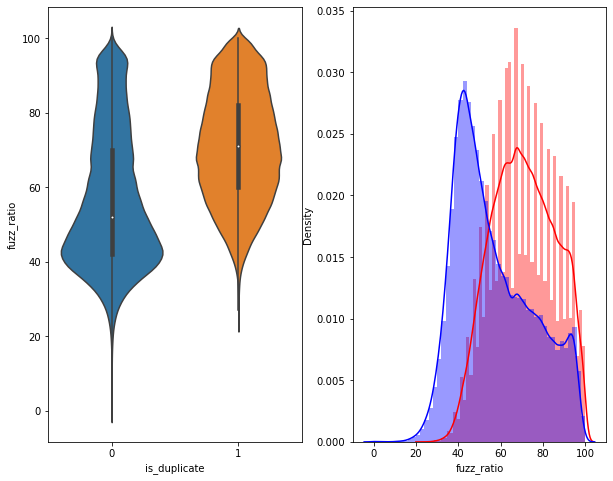

In [26]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = train_df[0:] , )

plt.subplot(1,2,2)
sns.distplot(train_df[train_df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(train_df[train_df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [27]:
for word in ['who', 'how', 'where', 'why', 'what', 'when', 'which']:
    train_df['have'+word+"_1"] = False
    train_df['have'+word+"_2"] = False
    train_df.loc[train_df.question1_clean.str.contains(r"\b"+word+"\\b", regex=True), ['have'+word+"_1"]] = True
    train_df.loc[train_df.question2_clean.str.contains(r"\b"+word+"\\b", regex=True), ['have'+word+"_2"]] = True
    train_df.loc[train_df.question1_clean.str.contains(r"\b"+word+"\\b", regex=True), ["question_word"+"_1"]] = word
    train_df.loc[train_df.question2_clean.str.contains(r"\b"+word+"\\b", regex=True), ["question_word"+"_2"]] = word

In [28]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,...,havewhere_1,havewhere_2,havewhy_1,havewhy_2,havewhat_1,havewhat_2,havewhen_1,havewhen_2,havewhich_1,havewhich_2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,...,False,False,False,False,True,True,False,False,False,False
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,...,False,False,False,False,True,True,False,False,False,False
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,...,False,False,False,False,False,False,False,False,False,False
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,...,False,False,True,False,False,False,False,True,False,False
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,...,False,False,False,False,False,False,False,False,True,True


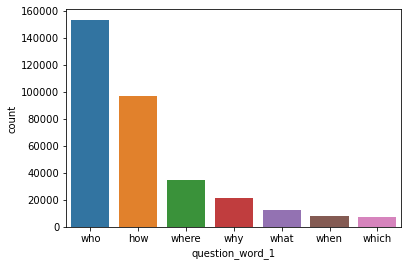

In [29]:
#Question word in Q1
g = sns.countplot(train_df["question_word_1"])
_=g.set_xticklabels(['who', 'how', 'where', 'why', 'what', 'when', 'which'])

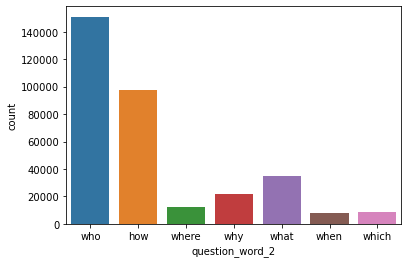

In [30]:
#Question word in Q2
g = sns.countplot(train_df["question_word_2"])
_=g.set_xticklabels(['who', 'how', 'where', 'why', 'what', 'when', 'which'])

In [31]:
train_df['have_same_q_w'] = False
train_df.loc[(train_df.is_duplicate == True) & (train_df.question_word_1==train_df.question_word_2),['have_same_q_w']] = True

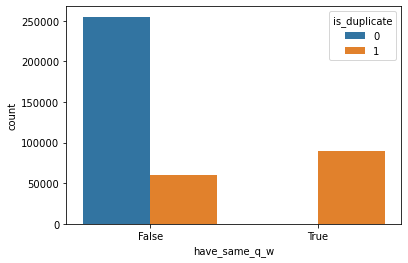

In [34]:
_=sns.countplot(x="have_same_q_w", hue="is_duplicate", data=train_df)

When two questions are duplicated, they have the same question word (who, where, what ...)